# LSTM baseline

from kuto

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [2]:
import os
import sys
import glob
import pickle
import random

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path


In [4]:
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [5]:
import pytorch_lightning as pl
# from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping

import wandb
from pytorch_lightning.loggers import WandbLogger

In [6]:
sys.path.append('../../')
import src.utils as utils

In [7]:
import multiprocessing
import scipy.interpolate
import scipy.sparse
from tqdm import tqdm

from indoor_location_competition_20.io_f import read_data_file
import indoor_location_competition_20.compute_f as compute_f

In [8]:
DATA_DIR = Path("/home/knikaido/work/Indoor-Location-Navigation/data/")
WIFI_DIR = DATA_DIR / 'indoorunifiedwifids_original'
MLFLOW_DIR = DATA_DIR / 'mlflow/mlruns'
OUTPUT_DIR = Path('./output/')
MLFLOW_DIR = DATA_DIR / 'mlflow/mlruns'

## config

In [9]:
configs = {
    'loss':{
        'name': 'MSELoss',
        'params':{}
    },
    'optimizer':{
        'name': 'Adam',
        'params':{
            'lr': 0.01,
        }
    },

    'scheduler':{
        'name': 'ReduceLROnPlateau',
        'params':{
            'factor': 0.1,
            'patience': 3,
        }
    },

    'loader':{
        'train':{
            'batch_size': 512,
            'shuffle': True,
            'num_workers': 4,
        },
        'valid':{
            'batch_size': 512,
            'shuffle': False,
            'num_workers': 4,
        },
        'test':{
            'batch_size': 512,
            'shuffle': False,
            'num_workers': 4,
        }
    }
}

In [10]:
# config
config = configs

# globals variable
SEED = 777
MAX_EPOCHS = 500
N_SPLITS = 5
DEBUG = False
# EXP_MESSAGE = config['globals']['exp_message']

EXP_NAME = 37
IS_SAVE = True

utils.set_seed(SEED)

In [11]:
!wandb login e8aaf98060af90035c3c28a83b34452780aeec20

/bin/sh: 1: wandb: not found


## read data

In [12]:
train_df = pd.read_csv(WIFI_DIR / 'train_7_th20000.csv')
test_df = pd.read_csv(WIFI_DIR / 'test_7_th20000.csv')

In [13]:
sub = pd.read_csv(DATA_DIR/'indoor-location-navigation/sample_submission.csv', index_col=0)

BSSIDとRSSIは100ずつ存在しているけど全てが必要なわけではないみたい  
ここでは20だけ取り出している。

In [14]:
# training target features
NUM_FEATS = 80
BSSID_FEATS = [f'bssid_{i}' for i in range(NUM_FEATS)]
RSSI_FEATS  = [f'rssi_{i}' for i in range(NUM_FEATS)]

In [15]:
train_df.iloc[:, 100:110]

,bssid_0,bssid_1,bssid_2,bssid_3,bssid_4,bssid_5,bssid_6,bssid_7,bssid_8,bssid_9
0,e9b24f94c0007acb4b7169b945622efcd332cf6f,591ea59cf88e3397db5d60eb00a5147edd69399a,590a4dd2afa1ad07090fd5f390f65a55e3dc5f56,a77f8e93896f8fc8bc0d0700ca04b802ee79a07f,1b2fd184314ae440900fa9ce1addeb896b5604a9,2c09230bb32ee49f6a72928f6eeefb6885dc15ce,3799b46aa4cf6c3c45c0bc27d8f1efefea96914f,fc6956beb062b5158252c66953e92a0d25495cac,c71a2f5c4282d27f84b9b841db0e310ef0fcf6cd,4f8b7c168dc76c9d3b4ca7903042173e98fe2ddb
1,e9b24f94c0007acb4b7169b945622efcd332cf6f,590a4dd2afa1ad07090fd5f390f65a55e3dc5f56,591ea59cf88e3397db5d60eb00a5147edd69399a,d32dd11040b254cd889c9ead2d4a50f6e3900196,9c832009dfb1ee02053c9ce9b7770b6cd3191003,509d1f842b0773e85c6beec0bb530542efd35cb9,1b2fd184314ae440900fa9ce1addeb896b5604a9,f920a2e4cb52165850990d9d37d391b630f7de14,6a42281c99a4cff2ce9dba3fc91ad6a431af64d9,fc6956beb062b5158252c66953e92a0d25495cac
2,590a4dd2afa1ad07090fd5f390f65a55e3dc5f56,e9b24f94c0007acb4b7169b945622efcd332cf6f,591ea59cf88e3397db5d60eb00a5147edd69399a,509d1f842b0773e85c6beec0bb530542efd35cb9,b2337b25e7d1df04928bf6698a9c0b2764df7795,76f81d5047273fa64a434457531d400fc5d90fac,6e388d1db5ba8dd9de80522a4ddf50402cf443b3,8c6ab78f2797e076f9106af81090d0ab9904f5cd,ceccac4f0e50ec9e36e8d2800b8f2c7c3b4d903e,f920a2e4cb52165850990d9d37d391b630f7de14
3,590a4dd2afa1ad07090fd5f390f65a55e3dc5f56,591ea59cf88e3397db5d60eb00a5147edd69399a,e9b24f94c0007acb4b7169b945622efcd332cf6f,6ec56c3efdeb067eb20bd2f4a6ccdae07d640cc1,d32dd11040b254cd889c9ead2d4a50f6e3900196,f920a2e4cb52165850990d9d37d391b630f7de14,6a42281c99a4cff2ce9dba3fc91ad6a431af64d9,9c832009dfb1ee02053c9ce9b7770b6cd3191003,509d1f842b0773e85c6beec0bb530542efd35cb9,0452e85d0a41780463cfe079077ea5bd2f519c7a
4,5875360455060f20a3cba705f44a4e3987c9b9f3,6ec56c3efdeb067eb20bd2f4a6ccdae07d640cc1,0452e85d0a41780463cfe079077ea5bd2f519c7a,3c7e7fa0576bc8a2af71d5899581df36f4dab6c8,09e103887f42552d20328aa41891cf82dace79ab,54bba3a36204f8c71b93798c31f9e0b039914575,18067f8d8861af3bcae51ba04b6b11b9150b9ff2,591ea59cf88e3397db5d60eb00a5147edd69399a,f920a2e4cb52165850990d9d37d391b630f7de14,d32dd11040b254cd889c9ead2d4a50f6e3900196
...,...,...,...,...,...,...,...,...,...,...
256744,5964a27e0cb3344b0a18540e6b3120c433971c38,d090a2f7f222fadeeb64e4fbdfe1ca8451116b04,cce41299a022ada08aebf3d309acb07d5f00b014,346b34a42e801c64e043dbaacbe7fef9b8880774,4b5dbdb52b131410ea10b59ea451de62280b41d6,fa11fc4d4960379cb68cc6968ba6415168fef53c,5f583dcccc43b5b7ac25d270e29c92d878fb2be0,5953d0b2247e16447d327eb2a8a9c1abe24ff425,4d2e5639041b40b0df2ee258aa504bd904133d80,dfc21edb1f7650d5645fd672bbe6a13fc6fd77f8
256745,5964a27e0cb3344b0a18540e6b3120c433971c38,346b34a42e801c64e043dbaacbe7fef9b8880774,d090a2f7f222fadeeb64e4fbdfe1ca8451116b04,cce41299a022ada08aebf3d309acb07d5f00b014,566e0c6e3bcf2b8b3d310d96f111043d17ace817,bd3fc24710537130e97dc2dab4a6bf70b3884a8b,4b5dbdb52b131410ea10b59ea451de62280b41d6,4d2e5639041b40b0df2ee258aa504bd904133d80,f4107af4418d57aacb3542343f7b47768debdc75,5f583dcccc43b5b7ac25d270e29c92d878fb2be0
256746,346b34a42e801c64e043dbaacbe7fef9b8880774,5964a27e0cb3344b0a18540e6b3120c433971c38,cce41299a022ada08aebf3d309acb07d5f00b014,566e0c6e3bcf2b8b3d310d96f111043d17ace817,bd3fc24710537130e97dc2dab4a6bf70b3884a8b,d090a2f7f222fadeeb64e4fbdfe1ca8451116b04,4b5dbdb52b131410ea10b59ea451de62280b41d6,a94eb920c0a198fe8385f3de6a8e8e6d44b6f6c9,ee5ca7a7deaacdcd5d99355ff5f156dc45b74efa,a7986c0cea5d2571ea42011ab4407039e977c0bd
256747,346b34a42e801c64e043dbaacbe7fef9b8880774,d090a2f7f222fadeeb64e4fbdfe1ca8451116b04,5964a27e0cb3344b0a18540e6b3120c433971c38,f4107af4418d57aacb3542343f7b47768debdc75,cce41299a022ada08aebf3d309acb07d5f00b014,4b5dbdb52b131410ea10b59ea451de62280b41d6,fa11fc4d4960379cb68cc6968ba6415168fef53c,a7986c0cea5d2571ea42011ab4407039e977c0bd,180a351ec58c07d60949862c534373c43f548a9a,4d2e5639041b40b0df2ee258aa504bd904133d80


bssid_NはN個目のBSSIDを示しておりRSSI値が大きい順に番号が振られている。
100個しかない


In [16]:
# get numbers of bssids to embed them in a layer

# train
wifi_bssids = []
# bssidを列ごとにリストに入れていく
for i in range(100, 200):
    wifi_bssids.extend(train_df.iloc[:,i].values.tolist())
wifi_bssids = list(set(wifi_bssids))

train_wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(train): {train_wifi_bssids_size}')

# test
wifi_bssids_test = []
for i in range(100, 200):
    wifi_bssids_test.extend(test_df.iloc[:,i].values.tolist())
wifi_bssids_test = list(set(wifi_bssids_test))

test_wifi_bssids_size = len(wifi_bssids_test)
print(f'BSSID TYPES(test): {test_wifi_bssids_size}')


wifi_bssids.extend(wifi_bssids_test)
wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(all): {wifi_bssids_size}')


BSSID TYPES(train): 61358
BSSID TYPES(test): 30658
BSSID TYPES(all): 92016


In [17]:
# get numbers of bssids to embed them in a layer

# train
rssi_bssids = []
# bssidを列ごとにリストに入れていく
for i in RSSI_FEATS:
    rssi_bssids.extend(train_df.loc[:,i].values.tolist())
rssi_bssids = list(set(rssi_bssids))

train_rssi_bssids_size = len(rssi_bssids)
print(f'RSSI TYPES(train): {train_rssi_bssids_size}')

# test
rssi_bssids_test = []
for i in RSSI_FEATS:
    rssi_bssids_test.extend(test_df.loc[:,i].values.tolist())
rssi_bssids_test = list(set(rssi_bssids_test))

test_rssi_bssids_size = len(rssi_bssids_test)
print(f'RSSI TYPES(test): {test_rssi_bssids_size}')


rssi_bssids.extend(rssi_bssids_test)
rssi_bssids_size = len(rssi_bssids)
print(f'RSSI TYPES(all): {rssi_bssids_size}')

RSSI TYPES(train): 98
RSSI TYPES(test): 77
RSSI TYPES(all): 175


## PreProcess

In [18]:
# preprocess

le = LabelEncoder()
le.fit(wifi_bssids)
le_site = LabelEncoder()
le_site.fit(train_df['site_id'])
le_rssi = LabelEncoder()
le_rssi.fit(rssi_bssids)

ss = StandardScaler()
ss.fit(train_df.loc[:,RSSI_FEATS])


def preprocess(input_df, le=le, le_site=le_site, ss=ss):
    output_df = input_df.copy()
    # RSSIの正規化
#     output_df.loc[:,RSSI_FEATS] = ss.transform(input_df.loc[:,RSSI_FEATS])

    # BSSIDのLE(1からふる)
    for i in BSSID_FEATS:
        output_df.loc[:,i] = le.transform(input_df.loc[:,i])
#         output_df.loc[:,i] = output_df.loc[:,i] + 1  # 0からではなく1から番号を振りたいため なぜ？
    for i in RSSI_FEATS:
        output_df.loc[:,i] = le_rssi.transform(input_df.loc[:,i])

    # site_idのLE
    output_df.loc[:, 'site_id'] = le_site.transform(input_df.loc[:, 'site_id'])

    # なぜ２重でやる？
#     output_df.loc[:,RSSI_FEATS] = ss.transform(output_df.loc[:,RSSI_FEATS])
    return output_df

train = preprocess(train_df)
test = preprocess(test_df)

train  

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,frequency_97,frequency_98,frequency_99,wp_tmestamp,x,y,floor,floor_str,path_id,site_id
0,b7e6027447eb1f81327d66cfd3adbe557aabf26c,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,8c1562bec17e1425615f3402f72dded3caa42ce5,b7e6027447eb1f81327d66cfd3adbe557aabf26c,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,2412,5765,2412,1578469851129,157.99141,102.125390,-1.0,B1,5e158ef61506f2000638fd1f,0
1,b7e6027447eb1f81327d66cfd3adbe557aabf26c,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,b7e6027447eb1f81327d66cfd3adbe557aabf26c,...,5180,5745,5745,1578469857653,162.93443,106.413020,-1.0,B1,5e158ef61506f2000638fd1f,0
2,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,5745,5825,5765,1578469857653,162.93443,106.413020,-1.0,B1,5e158ef61506f2000638fd1f,0
3,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b7e6027447eb1f81327d66cfd3adbe557aabf26c,da39a3ee5e6b4b0d3255bfef95601890afd80709,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,5745,5180,5180,1578469857653,162.93443,106.413020,-1.0,B1,5e158ef61506f2000638fd1f,0
4,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,5731b8e08abc69d4c4d685c58164059207c93310,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,7182afc4e5c212133d5d7d76eb3df6c24618302b,...,5765,2472,2452,1578469862177,168.49713,109.861336,-1.0,B1,5e158ef61506f2000638fd1f,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256744,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,4abd3985ba804364272767c04cdc211615f77c56,b5d43f6b4e1938ed497c7b589c6eae9ac0bee168,0a8a55cf161bc4980194ec9f7f7a448439be4b74,1f09251bbfadafb11c63c87963af25238d6bc886,da39a3ee5e6b4b0d3255bfef95601890afd80709,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,da39a3ee5e6b4b0d3255bfef95601890afd80709,...,0,0,0,1573733061352,203.53165,143.513960,6.0,F7,5dcd5c9323759900063d590a,23
256745,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,4abd3985ba804364272767c04cdc211615f77c56,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,b5d43f6b4e1938ed497c7b589c6eae9ac0bee168,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,4abd3985ba804364272767c04cdc211615f77c56,1f09251bbfadafb11c63c87963af25238d6bc886,...,0,0,0,1573733070079,192.57130,145.781450,6.0,F7,5dcd5c9323759900063d590a,23
256746,4abd3985ba804364272767c04cdc211615f77c56,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,1556355684145fce5e67ba749d943a180266ad9

In [19]:
site_count = len(train['site_id'].unique())
site_count

24

## PyTorch model
- embedding layerが重要  

In [20]:
# dataset
from torch.utils.data import Dataset, DataLoader
class IndoorDataset(Dataset):
    def __init__(self, df, phase='train'):
        self.df = df
        self.phase = phase
        self.bssid_feats = df[BSSID_FEATS].values.astype(int)
        self.rssi_feats = df[RSSI_FEATS].values.astype(int)
        self.site_id = df['site_id'].values.astype(int)

        if phase in ['train', 'valid']:
            self.xy = df[['x', 'y']].values.astype(np.float32)
            self.floor = df['floor'].values.astype(np.float32)
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        
        concat_feat = np.empty(2 * NUM_FEATS).astype(int)
        concat_feat[0::2] = self.bssid_feats[idx]
        concat_feat[1::2] = self.rssi_feats[idx]
        
        feature = {
            'RSSI_BSSID_FEATS':concat_feat,
            'site_id':self.site_id[idx]
        }
        if self.phase in ['train', 'valid']:
            target = {
                'xy':self.xy[idx],
                'floor':self.floor[idx]
            }
        else:
            target = {}
        return feature, target

In [21]:
import torch
from torch import nn

class LSTMModel(nn.Module):
    def __init__(self, bssid_size=94248, site_size=24, embedding_dim=64):
        super(LSTMModel, self).__init__()
        
        # bssid
        # ->64次元に圧縮後sequence化にする
        # wifi_bssids_sizeが辞書の数を表す
        self.bssid_embedding = nn.Embedding(bssid_size, 64, max_norm=True)
        # site
        # ->2次元に圧縮後sequence化する
        # site_countが辞書の数を表す       
        self.site_embedding = nn.Embedding(site_size, 64, max_norm=True)

        # rssi
        # 次元を64倍に線形変換
#         self.rssi_embedding = nn.Embedding(rssi_size, 64, max_norm=True)
#         self.rssi = nn.Sequential(
#             nn.BatchNorm1d(NUM_FEATS),
#             nn.Linear(NUM_FEATS, NUM_FEATS * 64)
#         )
        
        concat_size = 64 + (2 * NUM_FEATS * 64)
        self.linear_layer2 = nn.Sequential(
            nn.BatchNorm1d(concat_size),
            nn.Dropout(0.3),
            nn.Linear(concat_size, 256),
            nn.ReLU()
        )
        self.bn1 = nn.BatchNorm1d(concat_size)

        self.flatten = nn.Flatten()

        self.dropout1 = nn.Dropout(0.3)
        self.linear1 = nn.Linear(in_features=concat_size, out_features=256)#, bias=False)
        self.bn2 = nn.BatchNorm1d(256)

        self.batch_norm1 = nn.BatchNorm1d(1)
        self.lstm1 = nn.LSTM(input_size=256,hidden_size=128,dropout=0.3, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128,hidden_size=16,dropout=0.1, batch_first=True)

        self.fc_xy = nn.Linear(16, 2)
        # self.fc_x = nn.Linear(16, 1)
        # self.fc_y = nn.Linear(16, 1)
        self.fc_floor = nn.Linear(16, 1)

    
    def forward(self, x):
        # input embedding
        batch_size = x["site_id"].shape[0]
        x_bssid = self.bssid_embedding(x['RSSI_BSSID_FEATS'])
        x_bssid = self.flatten(x_bssid)
        
        x_site_id = self.site_embedding(x['site_id'])
        x_site_id = self.flatten(x_site_id)

#         x_rssi = self.rssi_embedding(x['RSSI_FEATS'])
#         x_rssi = self.flatten(x_rssi)

        x = torch.cat([x_bssid, x_site_id], dim=1)
        x = self.linear_layer2(x)

        # lstm layer
        x = x.view(batch_size, 1, -1)  # [batch, 1]->[batch, 1, 1]
        x = self.batch_norm1(x)
        x, _ = self.lstm1(x)
        x = torch.relu(x)
        x, _ = self.lstm2(x)
        x = torch.relu(x)

        # output [batch, 1, 1] -> [batch]
        # x_ = self.fc_x(x).view(-1)
        # y_ = self.fc_y(x).view(-1)
        xy = self.fc_xy(x).squeeze(1)
        floor = torch.relu(self.fc_floor(x)).view(-1)
        # return {"x":x_, "y":y_, "floor":floor} 
        return {"xy": xy, "floor": floor}

In [22]:
def mean_position_error(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]

def to_np(input):
    return input.detach().cpu().numpy()

In [23]:
def get_optimizer(model: nn.Module, config: dict):
    optimizer_config = config["optimizer"]
    optimizer_name = optimizer_config.get("name")
    base_optimizer_name = optimizer_config.get("base_name")
    optimizer_params = optimizer_config['params']

    if hasattr(optim, optimizer_name):
        optimizer = optim.__getattribute__(optimizer_name)(model.parameters(), **optimizer_params)
        return optimizer
    else:
        base_optimizer = optim.__getattribute__(base_optimizer_name)
        optimizer = globals().get(optimizer_name)(
            model.parameters(), 
            base_optimizer,
            **optimizer_config["params"])
        return  optimizer

def get_scheduler(optimizer, config: dict):
    scheduler_config = config["scheduler"]
    scheduler_name = scheduler_config.get("name")

    if scheduler_name is None:
        return
    else:
        return optim.lr_scheduler.__getattribute__(scheduler_name)(
            optimizer, **scheduler_config["params"])


def get_criterion(config: dict):
    loss_config = config["loss"]
    loss_name = loss_config["name"]
    loss_params = {} if loss_config.get("params") is None else loss_config.get("params")
    if hasattr(nn, loss_name):
        criterion = nn.__getattribute__(loss_name)(**loss_params)
    else:
        criterion = globals().get(loss_name)(**loss_params)

    return criterion

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [24]:
# Learner class(pytorch-lighting)
class Learner(pl.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.config = config
        self.xy_criterion = get_criterion(config)
        self.f_criterion = get_criterion(config)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        loss = self.xy_criterion(output["xy"], y["xy"])
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        xy_loss = self.xy_criterion(output["xy"], y["xy"])
        f_loss = self.f_criterion(output["floor"], y["floor"])
        loss = xy_loss  # + f_loss
        mpe = mean_position_error(
            to_np(output['xy'][:, 0]), to_np(output['xy'][:, 1]), 0, 
            to_np(y['xy'][:, 0]), to_np(y['xy'][:, 1]), 0)
        
        # floor lossは現状は無視して良い
        self.log(f'Loss/val', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/xy', xy_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/floor', f_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'MPE/val', mpe, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        return mpe
    
    def validation_epoch_end(self, outputs):
        avg_loss = np.mean(outputs)
        print(f'epoch = {self.current_epoch}, mpe_loss = {avg_loss}')

    def configure_optimizers(self):
        optimizer = get_optimizer(self.model, self.config)
        scheduler = get_scheduler(optimizer, self.config)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "Loss/val"}

In [25]:
# oof
def evaluate(model, loaders, phase):
    x_list = []
    y_list = []
    f_list = []
    with torch.no_grad():
        for batch in loaders[phase]:
            x, y = batch
            output = model(x)
            x_list.append(to_np(output['xy'][:, 0]))
            y_list.append(to_np(output['xy'][:, 1]))
            f_list.append(to_np(output['floor']))

    x_list = np.concatenate(x_list)
    y_list = np.concatenate(y_list)
    f_list = np.concatenate(f_list)
    return x_list, y_list, f_list

## train

In [26]:
oofs = np.zeros((len(train), 2), dtype = np.float32)  # 全てのoofをdfで格納する
predictions = []  # 全ての予測値をdfで格納する
val_scores = []
# skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
gkf = GroupKFold(n_splits=N_SPLITS)
# for fold, (trn_idx, val_idx) in enumerate(skf.split(train.loc[:, 'path'], train.loc[:, 'path'])):
for fold, (trn_idx, val_idx) in enumerate(gkf.split(train.loc[:, 'path_id'], groups=train.loc[:, 'path_id'])):

    # 指定したfoldのみループを回す

    print('=' * 20)
    print(f'Fold {fold}')
    print('=' * 20)

    # train/valid data
    trn_df = train.loc[trn_idx, BSSID_FEATS + RSSI_FEATS + ['site_id', 'x','y','floor']].reset_index(drop=True)
    val_df = train.loc[val_idx, BSSID_FEATS + RSSI_FEATS + ['site_id', 'x','y','floor']].reset_index(drop=True)

    # data loader
    loaders = {}
    loader_config = config["loader"]
    loaders["train"] = DataLoader(IndoorDataset(trn_df, phase="train"), **loader_config["train"], worker_init_fn=worker_init_fn) 
    loaders["valid"] = DataLoader(IndoorDataset(val_df, phase="valid"), **loader_config["valid"], worker_init_fn=worker_init_fn)
    loaders["test"] = DataLoader(IndoorDataset(test, phase="test"), **loader_config["test"], worker_init_fn=worker_init_fn)
    
    # model
    model = LSTMModel(wifi_bssids_size+rssi_bssids_size, site_count)
    model_name = model.__class__.__name__
    
    # loggers
    RUN_NAME = f'exp{str(EXP_NAME)}'
    wandb.init(project='Indoor_Location_Navigation', entity='sqrt4kaido', group=RUN_NAME, job_type=RUN_NAME + f'-fold-{fold}')
    wandb.run.name = RUN_NAME + f'-fold-{fold}'
    wandb_config = wandb.config
    wandb_config.model_name = model_name
    wandb.watch(model)
    
    
    loggers = []
    loggers.append(WandbLogger())

    learner = Learner(model, config)
    
    # callbacks
    callbacks = []
    checkpoint_callback = ModelCheckpoint(
        monitor=f'Loss/val',
        mode='min',
        dirpath=OUTPUT_DIR,
        verbose=False,
        filename=f'{model_name}-{learner.current_epoch}-{fold}')
    callbacks.append(checkpoint_callback)

    early_stop_callback = EarlyStopping(
        monitor='Loss/val',
        min_delta=0.00,
        patience=20,
        verbose=True,
        mode='min')
    callbacks.append(early_stop_callback)
    
    trainer = pl.Trainer(
        logger=loggers,
        callbacks=callbacks,
        max_epochs=MAX_EPOCHS,
        default_root_dir=OUTPUT_DIR,
        gpus=1,
        fast_dev_run=DEBUG,
        deterministic=True,
        benchmark=True,
#         precision=16,
#         progress_bar_refresh_rate=0  # vscodeの時progress barの動作が遅いので表示しない
        )


    trainer.fit(learner, train_dataloader=loaders['train'], val_dataloaders=loaders['valid'])

    #############
    # validation (to make oof)
    #############
    model.eval()
    oof_x, oof_y, oof_f = evaluate(model, loaders, phase="valid")
    oofs[val_idx, 0] = oof_x
    oofs[val_idx, 1] = oof_y

    
    val_score = mean_position_error(
        oof_x, oof_y, 0,
        val_df['x'].values, val_df['y'].values, 0)
    val_scores.append(val_score)
    print(f"fold {fold}: mean position error {val_score}")

    #############
    # inference
    #############
    preds_x, preds_y, preds_f = evaluate(model, loaders, phase="test")
    test_preds = pd.DataFrame(np.stack((preds_f, preds_x, preds_y))).T
    test_preds.columns = sub.columns
    test_preds["site_path_timestamp"] = test["site_path_timestamp"]
    test_preds["floor"] = test_preds["floor"].astype(int)
    predictions.append(test_preds)
    

Fold 0


/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
wandb: Currently logged in as: sqrt4kaido (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.4 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.707    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 125.93562316894531


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 139.9743316000759


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 119.29829926443571


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 103.24868121081059


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 91.92370892540457


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 84.77692168182271


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 80.80449382467239


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 67.29989932497736


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 61.83574210088245


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 58.3773725327092


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 49.081872191728145


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 42.03069830211476


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 34.87886331312727


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 29.03256153761357


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 25.045794058318183


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 22.397930790174126


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 20.069823624639227


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 18.048608277638753


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 16.318778023735526


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 14.588269514770005


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 13.427571032936424


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 12.591266633653799


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 11.760606368603094


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 11.216949632726488


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 11.11620451275665


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 10.867307702306867


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 9.810618946528672


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 10.386270806781528


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 9.261932653798523


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 8.89633018625845


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 8.941418138195578


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 8.941183512785253


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 8.718557088115428


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 9.245490644347942


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 8.545662887120011


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 8.600609714709492


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 8.44964661022224


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 8.461922348513461


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 8.28663133249818


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 9.849403849812624


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 8.3083275264954


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 8.052732045642614


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 8.054884097662695


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 8.25834280121051


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 9.017003127623706


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 8.422101294010778


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 7.638181597139969


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 7.544106676019851


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 7.524952225637907


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 7.529532973097496


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 7.519707746600161


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 7.495263518531724


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 7.4907758511961875


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 7.493514762664391


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 7.489236858166484


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 7.4727535155268


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 7.458280209267493


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 7.471260693742104


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 7.469074529263839


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 7.468903049242378


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 7.4413108069039025


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 7.461416524440148


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 7.455940963317065


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 7.463099245253963


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 7.451756273905437


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 7.4218587524111905


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 7.414129085729618


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 7.410104885793755


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 7.400366923958555


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 7.4081592125467735


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 7.401962696239106


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 7.400169811878267


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 7.400228542038316


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 7.403661387604062


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 7.390547113387105


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 7.413920451186278


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 7.394846368544172


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 7.4047931990292994


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 7.401674335530095


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 7.400697811932454


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 7.4012830547295


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 7.4008765802289


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 7.39513020273089


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 7.4028278066301505


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 7.400953787057707


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 7.396522812040726


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 7.4047078280559075


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 7.398199290914505


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 7.405567989475263


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 7.401415997936388


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 7.393083119219286


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 7.393082846650983


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 7.400693172542962


Validating: 0it [00:00, ?it/s]

epoch = 92, mpe_loss = 7.394503590989821


Validating: 0it [00:00, ?it/s]

epoch = 93, mpe_loss = 7.401876632514173
fold 0: mean position error 7.387024152829779
Fold 1


/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Loss/val,41.17938
Loss/xy,41.17938
Loss/floor,5.71776
MPE/val,7.38702
epoch,93
trainer/global_step,37787
_runtime,428
_timestamp,1618881923
_step,93


Loss/val,█▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MPE/val,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.4 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.707    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 171.31221389770508


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 120.83034588653263


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 94.51006728874181


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 73.8225670215871


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 59.818897508929666


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 53.88398056584222


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 45.94816186042509


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 40.098131866329176


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 33.846017593408966


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 28.183780570769862


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 25.15077001943053


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 20.82931650369474


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 18.103811494178895


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 16.29819184570816


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 14.32846807505038


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 13.179293084475074


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 12.484367041005552


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 11.98442673314916


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 11.337045146388188


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 10.396572486701183


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 10.687699092764273


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 9.85417468930235


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 9.644899163702535


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 9.395800082896015


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 9.078373108099003


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 9.861765821979384


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 8.979888299369183


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 8.777725457106486


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 8.81302021410599


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 9.056824138628768


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 9.807603147714445


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 8.64438886327712


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 8.358814366406733


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 8.408563793610424


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 8.446408495572534


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 9.284678345607846


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 8.43600420778734


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 8.274357477949792


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 8.234445469229922


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 8.433431114473752


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 8.271878951736802


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 8.052896725305237


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 8.213007846177609


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 8.175262074801001


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 8.16191901713708


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 8.4871658945241


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 8.201348542946794


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 8.494311702967478


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 7.64171271497267


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 7.559850180471691


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 7.530233286363457


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 7.4961380931489145


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 7.482512988351753


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 7.485622478963519


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 7.48886681408772


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 7.470277528857241


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 7.456356804976762


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 7.4805472578546


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 7.460014317263864


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 7.482108702832716


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 7.487854313047806


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 7.458166686772513


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 7.4508609962463375


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 7.451530119326248


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 7.442987188962427


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 7.454836522470606


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 7.444850542742033


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 7.444427668883068


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 7.445524209844004


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 7.436101273199907


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 7.450783362939412


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 7.4560192930265625


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 7.447808910533539


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 7.441375633340464


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 7.449593377758568


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 7.445164325386777


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 7.446791194626207
fold 1: mean position error 7.438212305655019
Fold 2


Loss/val,43.26635
Loss/xy,43.26635
Loss/floor,4.4723
MPE/val,7.43821
epoch,75
trainer/global_step,30551
_runtime,352
_timestamp,1618882281
_step,75


Loss/val,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▁▁▃▅▅▆▆▇▇▇▇█████████████████████████████
MPE/val,█▆▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.4 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.707    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 139.93199920654297


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 111.32113630162607


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 86.95880682362974


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 80.6500955900186


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 63.440351502572746


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 56.23842609430697


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 52.897036811652356


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 51.14322928601759


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 49.84734943805355


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 49.43150876992607


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 48.189467000678036


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 38.88604180968634


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 29.1263553397805


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 22.515729691219015


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 18.781487845745023


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 16.418070237439853


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 14.712984844560278


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 13.163834311859835


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 12.559452299237645


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 12.225061935324087


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 11.632946369120782


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 11.138969354031502


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 10.394977170232893


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 10.117918290430957


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 9.652701039518853


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 10.008530949696455


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 9.6077832869728


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 9.493815938804802


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 9.625119930934591


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 9.044528926937494


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 9.15175370169158


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 9.115555870572333


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 9.243118802942458


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 9.08546432501412


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 8.926852140898752


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 9.00220894816685


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 8.679707726330648


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 8.639054688620488


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 8.747630792120502


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 8.792361314918342


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 8.53792698750008


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 9.021122274556177


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 8.614414921121629


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 8.613371897908326


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 8.758568175287529


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 8.765944057691215


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 8.420822788653988


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 8.338256546750713


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 8.68468933886034


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 8.45524298778068


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 8.376622758116266


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 9.749081462381698


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 8.375741905174634


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 8.205358549061389


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 8.454479471087062


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 8.53241362297889


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 9.364860741077083


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 8.435828364721619


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 7.8257403921372815


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 7.758558169701705


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 7.737943250637243


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 7.692475635478205


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 7.694685979660588


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 7.6772843479874116


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 7.64792788540176


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 7.661153687140335


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 7.6607882533057685


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 7.658361473712985


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 7.645001305872851


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 7.616104686661522


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 7.609690091853881


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 7.612303831396323


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 7.601928015290314


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 7.607268516364271


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 7.604072935085486


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 7.605918577779637


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 7.603270856460722


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 7.6058126061820355


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 7.599922026517762


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 7.604937736901513


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 7.605623818702824


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 7.619212080322869


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 7.608454911134424


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 7.60284139878679


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 7.6093094394545355


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 7.6083006594440725


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 7.610871166443274


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 7.60224926259258


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 7.607678150391028


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 7.601537074979777


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 7.606459673639177


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 7.60197762246966


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 7.611153843379257


Validating: 0it [00:00, ?it/s]

epoch = 92, mpe_loss = 7.607024424272796
fold 2: mean position error 7.59622565625511
Fold 3


Loss/val,47.22449
Loss/xy,47.22449
Loss/floor,5.16896
MPE/val,7.59623
epoch,92
trainer/global_step,37385
_runtime,433
_timestamp,1618882720
_step,92


Loss/val,█▅▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,██▅▁▁▃▆▆▇▇██████████████████████████████
MPE/val,█▆▄▄▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.4 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.707    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 145.22705841064453


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 130.51142869351327


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 104.52857371868474


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 90.20597015481577


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 84.0350024444278


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 62.28994935466905


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 55.74017466831522


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 51.15073274857927


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 45.18749315784316


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 37.830666840178736


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 31.744849660199858


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 27.02107124083113


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 23.419881413148183


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 20.338090141598542


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 18.287784460779072


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 16.23387738054735


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 14.965900515376932


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 13.388266935379987


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 12.608632412712174


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 11.768312063248636


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 11.252162237765372


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 10.924908795561334


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 10.596577443289679


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 10.13032883886457


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 9.859523897517239


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 9.578209588330964


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 9.594791755361525


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 8.9657230548418


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 8.841884771038597


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 9.029443713336102


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 8.737606481419931


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 9.003372577881263


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 8.732823782061587


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 8.730844521223515


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 8.809727080505674


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 9.45467140827242


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 9.187057333590568


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 8.429159233294698


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 8.347492342089662


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 8.409448108043607


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 8.670328805879398


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 8.472887519924553


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 8.809894599159165


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 7.845416078598979


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 7.745320060087903


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 7.715019208511504


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 7.695094580634592


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 7.682527122182814


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 7.675021069907513


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 7.6501080095649945


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 7.635560052953538


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 7.6549861988533445


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 7.6446356702244325


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 7.646767389908089


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 7.642762278062676


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 7.613321011546422


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 7.6026312795330595


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 7.5999651909504005


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 7.59900898684763


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 7.594356725522787


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 7.595351503800244


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 7.596798592652425


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 7.5956484679420395


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 7.595430133177502


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 7.604703521350823


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 7.605429049450966


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 7.59844872392837


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 7.588586898086095


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 7.592499196647418


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 7.600252703361386


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 7.593397358211353


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 7.592691244307918


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 7.5963352650935105


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 7.599636108725771


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 7.597541498303807


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 7.591379560338388


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 7.595040403089114


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 7.6017458633385075


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 7.587695338434906


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 7.5856091577070375


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 7.600649680870989


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 7.586046765928615


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 7.590944366392129


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 7.603078386665571


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 7.599714652524136


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 7.589731417079963


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 7.583426972537151


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 7.596092800354406


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 7.591979015652496


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 7.587678111646041


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 7.593942092983636


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 7.587770153461117


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 7.58620428563738


Validating: 0it [00:00, ?it/s]

epoch = 92, mpe_loss = 7.596607914411589


Validating: 0it [00:00, ?it/s]

epoch = 93, mpe_loss = 7.603308750442153


Validating: 0it [00:00, ?it/s]

epoch = 94, mpe_loss = 7.5860432400089675


Validating: 0it [00:00, ?it/s]

epoch = 95, mpe_loss = 7.60212967775049


Validating: 0it [00:00, ?it/s]

epoch = 96, mpe_loss = 7.600551137452078


Validating: 0it [00:00, ?it/s]

epoch = 97, mpe_loss = 7.589674918423392


Validating: 0it [00:00, ?it/s]

epoch = 98, mpe_loss = 7.583896240542824


Validating: 0it [00:00, ?it/s]

epoch = 99, mpe_loss = 7.6031887260600675


Validating: 0it [00:00, ?it/s]

epoch = 100, mpe_loss = 7.596809254825706


Validating: 0it [00:00, ?it/s]

epoch = 101, mpe_loss = 7.59615766241999


Validating: 0it [00:00, ?it/s]

epoch = 102, mpe_loss = 7.598969183880897


Validating: 0it [00:00, ?it/s]

epoch = 103, mpe_loss = 7.5958102398107545


Validating: 0it [00:00, ?it/s]

epoch = 104, mpe_loss = 7.596258531639679


Validating: 0it [00:00, ?it/s]

epoch = 105, mpe_loss = 7.594172610229391


Validating: 0it [00:00, ?it/s]

epoch = 106, mpe_loss = 7.588798509887343


Validating: 0it [00:00, ?it/s]

epoch = 107, mpe_loss = 7.594919380905604


Validating: 0it [00:00, ?it/s]

epoch = 108, mpe_loss = 7.594251007325578


Validating: 0it [00:00, ?it/s]

epoch = 109, mpe_loss = 7.592805716889133


Validating: 0it [00:00, ?it/s]

epoch = 110, mpe_loss = 7.60496316887758


Validating: 0it [00:00, ?it/s]

epoch = 111, mpe_loss = 7.5968076616860065
fold 3: mean position error 7.590342234802021
Fold 4


Loss/val,45.49789
Loss/xy,45.49789
Loss/floor,4.55794
MPE/val,7.59034
epoch,111
trainer/global_step,45023
_runtime,520
_timestamp,1618883245
_step,111


Loss/val,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▄▄█▄▅▅▅▅▄▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MPE/val,█▆▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.4 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.707    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 152.01006317138672


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 129.04107277296225


Validating: 0it [00:00, ?it/s]

epoch = 1, mpe_loss = 103.27026999303294


Validating: 0it [00:00, ?it/s]

epoch = 2, mpe_loss = 89.36705675061117


Validating: 0it [00:00, ?it/s]

epoch = 3, mpe_loss = 83.36963127253341


Validating: 0it [00:00, ?it/s]

epoch = 4, mpe_loss = 81.59252434833887


Validating: 0it [00:00, ?it/s]

epoch = 5, mpe_loss = 81.37297430855308


Validating: 0it [00:00, ?it/s]

epoch = 6, mpe_loss = 81.48082070721686


Validating: 0it [00:00, ?it/s]

epoch = 7, mpe_loss = 81.554643285608


Validating: 0it [00:00, ?it/s]

epoch = 8, mpe_loss = 75.07477865042311


Validating: 0it [00:00, ?it/s]

epoch = 9, mpe_loss = 55.51207115208321


Validating: 0it [00:00, ?it/s]

epoch = 10, mpe_loss = 46.466452907126516


Validating: 0it [00:00, ?it/s]

epoch = 11, mpe_loss = 40.56401392309141


Validating: 0it [00:00, ?it/s]

epoch = 12, mpe_loss = 34.43736652548792


Validating: 0it [00:00, ?it/s]

epoch = 13, mpe_loss = 29.334159192203074


Validating: 0it [00:00, ?it/s]

epoch = 14, mpe_loss = 25.303052921233064


Validating: 0it [00:00, ?it/s]

epoch = 15, mpe_loss = 21.940430900014288


Validating: 0it [00:00, ?it/s]

epoch = 16, mpe_loss = 19.476005711993693


Validating: 0it [00:00, ?it/s]

epoch = 17, mpe_loss = 17.350240994849564


Validating: 0it [00:00, ?it/s]

epoch = 18, mpe_loss = 15.595711926066034


Validating: 0it [00:00, ?it/s]

epoch = 19, mpe_loss = 14.296853362765374


Validating: 0it [00:00, ?it/s]

epoch = 20, mpe_loss = 14.7075704871416


Validating: 0it [00:00, ?it/s]

epoch = 21, mpe_loss = 12.083052695142097


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 13.555940897062818


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 11.325876986309495


Validating: 0it [00:00, ?it/s]

epoch = 24, mpe_loss = 10.609915020315503


Validating: 0it [00:00, ?it/s]

epoch = 25, mpe_loss = 10.218540149445122


Validating: 0it [00:00, ?it/s]

epoch = 26, mpe_loss = 10.140220489460129


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 10.325567969595271


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 9.924578709811165


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 9.38576791021735


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 9.215078377867863


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 9.167614852925047


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 9.132764335613059


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 9.721037038228577


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 8.951355421025852


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 9.30986883512121


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 8.735578539015185


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 8.637988051890344


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 8.790412004734323


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 8.83462130292261


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 8.661768530221371


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 8.531317522188493


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 9.259446433520617


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 8.499681788208841


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 8.488294470610432


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 9.295044618125326


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 8.41796671030046


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 8.900929443384216


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 8.444060140008094


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 8.344068738026225


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 8.925765376572942


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 8.454468529076582


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 8.789264590108552


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 8.389847198557051


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 7.757397936114331


Validating: 0it [00:00, ?it/s]

epoch = 55, mpe_loss = 7.686150887945781


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 7.668523343966027


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 7.648474969121814


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 7.629255715838556


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 7.61075869046364


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 7.646261112358381


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 7.644086372908567


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 7.627234305976768


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 7.6166256452384635


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 7.633661424102114


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 7.632877439587241


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 7.621525717190361


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 7.618889227603565


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 7.594412745031473


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 7.582589690475672


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 7.575983699385657


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 7.574753302483473


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 7.577924548577562


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 7.574756831376289


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 7.58558894730983


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 7.572349547009047


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 7.583721888676079


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 7.574914132220316


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 7.569544043348623


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 7.566810054013528


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 7.574006703091789


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 7.571120525010045


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 7.58130656829252


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 7.581732710141805


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 7.565899813576817


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 7.577984465389237


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 7.578958389996547


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 7.572663832284325


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 7.566241983353747


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 7.57699720087507


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 7.57268223504908


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 7.576940882411128


Validating: 0it [00:00, ?it/s]

epoch = 92, mpe_loss = 7.573832886774632


Validating: 0it [00:00, ?it/s]

epoch = 93, mpe_loss = 7.572211521647287


Validating: 0it [00:00, ?it/s]

epoch = 94, mpe_loss = 7.571161794570587


Validating: 0it [00:00, ?it/s]

epoch = 95, mpe_loss = 7.576600723880035


Validating: 0it [00:00, ?it/s]

epoch = 96, mpe_loss = 7.57091955010919


Validating: 0it [00:00, ?it/s]

epoch = 97, mpe_loss = 7.5681776951314506


Validating: 0it [00:00, ?it/s]

epoch = 98, mpe_loss = 7.577909432595668


Validating: 0it [00:00, ?it/s]

epoch = 99, mpe_loss = 7.572480042025578
fold 4: mean position error 7.553656468324021


In [27]:
oofs_df = pd.DataFrame(oofs, columns=['x', 'y'])
oofs_df['path'] = train_df['path_id']
oofs_df['timestamp'] = train_df['wp_tmestamp']
oofs_df['site'] = train_df['site_id']
oofs_df['site_path_timestamp'] = oofs_df['site'] + '_' + oofs_df['path'] + '_' + oofs_df['timestamp'].astype(str)
oofs_df['floor'] = train_df['floor']
oofs_df.to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}.csv", index=False)
oofs_df

,x,y,path,timestamp,site,site_path_timestamp,floor
0,161.727921,105.245316,5e158ef61506f2000638fd1f,1578469851129,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
1,162.383804,103.362061,5e158ef61506f2000638fd1f,1578469857653,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
2,162.373886,110.264458,5e158ef61506f2000638fd1f,1578469857653,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
3,161.387253,112.172440,5e158ef61506f2000638fd1f,1578469857653,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
4,162.902756,113.944183,5e158ef61506f2000638fd1f,1578469862177,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
...,...,...,...,...,...,...,...
256744,191.343048,144.767349,5dcd5c9323759900063d590a,1573733061352,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0
256745,194.045959,142.485641,5dcd5c9323759900063d590a,1573733070079,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0
256746,187.881866,144.216461,5dcd5c9323759900063d590a,1573733070079,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0
256747,189.237259,143.970062,5dcd5c9323759900063d590a,1573733070079,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0


In [28]:
oofs_score = mean_position_error(
        oofs_df['x'], oofs_df['y'], 0,
        train_df['x'].values, train_df['y'].values, 0)
print(f"CV:{oofs_score}")

CV:7.513092005581126


In [29]:
# foldの結果を平均した後、reindexでsubmission fileにindexを合わせる
all_preds = pd.concat(predictions).groupby('site_path_timestamp').mean()
all_preds.index = sub.index
all_preds

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,88.266884,104.794296
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,82.316628,104.338745
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,84.221382,105.362061
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,87.842506,109.344193
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,87.390121,108.134903
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,0,214.121277,98.048187
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,0,211.845245,100.757538
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,0,208.958572,107.238953


In [30]:
# floorの数値を置換
simple_accurate_99 = pd.read_csv('../01/submission.csv')
all_preds['floor'] = simple_accurate_99['floor'].values
all_preds.to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}.csv")
all_preds

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,88.266884,104.794296
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,82.316628,104.338745
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,84.221382,105.362061
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,87.842506,109.344193
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,87.390121,108.134903
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,5,214.121277,98.048187
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,5,211.845245,100.757538
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,5,208.958572,107.238953


# Post Proccess

In [31]:
oofs_df = pd.read_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}.csv")
sub_df = pd.read_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}.csv")

In [32]:
def compute_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_f.compute_steps(acce_datas)
    headings = compute_f.compute_headings(ahrs_datas)
    stride_lengths = compute_f.compute_stride_length(step_acce_max_mins)
    step_headings = compute_f.compute_step_heading(step_timestamps, headings)
    rel_positions = compute_f.compute_rel_positions(stride_lengths, step_headings)
    return rel_positions

In [33]:
def correct_path(args):

    path, path_df = args
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    txt_path = path_df['txt_path'].values[0]
    
    example = read_data_file(txt_path)
    rel_positions = compute_rel_positions(example.acce, example.ahrs)
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    T_rel = rel_positions[:, 0]
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)

    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })

In [34]:
tmp = sub_df['site_path_timestamp'].apply(lambda s : pd.Series(s.split('_')))
sub_df['site'] = tmp[0]
sub_df['path'] = tmp[1]
sub_df['timestamp'] = tmp[2].astype(float)

In [35]:
used_buildings = sorted(sub_df['site'].value_counts().index.tolist())
test_txts = sorted(glob.glob(str(DATA_DIR/'indoor-location-navigation') + f'/test/*.txt'))
train_txts = [sorted(glob.glob(str(DATA_DIR/'indoor-location-navigation') + f'/train/{used_building}/*/*.txt')) for used_building in used_buildings]
train_txts = sum(train_txts, [])

In [36]:
txt_pathes = []
for path in tqdm(sub_df['path'].values):
    txt_pathes.append([test_txt for test_txt in test_txts if path in test_txt][0])

100%|██████████| 10133/10133 [00:00<00:00, 27633.52it/s]


In [37]:
sub_df['txt_path'] = txt_pathes

In [38]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, sub_df.groupby('path'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
sub_df_cm = pd.concat(dfs).sort_values('site_path_timestamp')

626it [01:09,  9.06it/s]


In [39]:
txt_pathes = []
for path in tqdm(oofs_df['path'].values):
    txt_pathes.append([train_txt for train_txt in train_txts if path in train_txt][0])

100%|██████████| 256749/256749 [02:29<00:00, 1721.42it/s]


In [40]:
oofs_df['txt_path'] = txt_pathes

In [41]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, oofs_df.groupby('path'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
oofs_df_cm = pd.concat(dfs).sort_index()
oofs_df_cm

10836it [08:09, 22.16it/s]


,site_path_timestamp,floor,x,y
0,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,158.994793,105.517434
1,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,162.059669,109.127614
2,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,162.055475,109.135896
3,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,162.050844,109.142630
4,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,165.614839,112.064883
...,...,...,...,...
256744,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,200.188891,141.983313
256745,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,186.015142,145.308557
256746,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,186.026983,145.305070
256747,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,186.036279,145.303076


In [42]:
oofs_df_cm.to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_cm.csv", index=False)

In [43]:
oofs_score = mean_position_error(
        oofs_df_cm['x'], oofs_df_cm['y'], 0,
        train_df['x'].values, train_df['y'].values, 0)
print(f"CV:{oofs_score}")

CV:5.923102509132093


In [44]:
sub_df_cm.to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_cm.csv", index=False)

In [45]:
oofs_df_cm = pd.read_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_cm.csv")

In [46]:
sub_df_cm = pd.read_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_cm.csv")

In [47]:
def split_col(df):
    df = pd.concat([
        df['site_path_timestamp'].str.split('_', expand=True) \
        .rename(columns={0:'site',
                         1:'path',
                         2:'timestamp'}),
        df
    ], axis=1).copy()
    return df
def sub_process(sub, train_waypoints):
    train_waypoints['isTrainWaypoint'] = True
    sub = split_col(sub[['site_path_timestamp','floor','x','y']]).copy()
    sub = sub.merge(train_waypoints[['site','floorNo','floor']].drop_duplicates(), how='left')
    sub = sub.merge(
        train_waypoints[['x','y','site','floor','isTrainWaypoint']].drop_duplicates(),
        how='left',
        on=['site','x','y','floor']
             )
    sub['isTrainWaypoint'] = sub['isTrainWaypoint'].fillna(False)
    return sub.copy()

In [48]:
train_waypoints = pd.read_csv(str(DATA_DIR/'indoor-location-navigation') + '/train_waypoints.csv')


In [49]:
sub_df_cm = sub_process(sub_df_cm, train_waypoints)
oofs_df_cm = sub_process(oofs_df_cm, train_waypoints)

In [50]:
from scipy.spatial.distance import cdist

def add_xy(df):
    df['xy'] = [(x, y) for x,y in zip(df['x'], df['y'])]
    return df

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

sub_df_cm = add_xy(sub_df_cm)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in tqdm(sub_df_cm.groupby(['site','floor'])):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

sub_df_cm_ds = pd.concat(ds)


oofs_df_cm = add_xy(oofs_df_cm)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in tqdm(oofs_df_cm.groupby(['site','floor'])):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

oofs_df_cm_ds = pd.concat(ds)

  0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [51]:
def snap_to_grid(sub, threshold):
    """
    Snap to grid if within a threshold.
    
    x, y are the predicted points.
    x_, y_ are the closest grid points.
    _x_, _y_ are the new predictions after post processing.
    """
    sub['_x_'] = sub['x']
    sub['_y_'] = sub['y']
    sub.loc[sub['dist'] < threshold, '_x_'] = sub.loc[sub['dist'] < threshold]['x_']
    sub.loc[sub['dist'] < threshold, '_y_'] = sub.loc[sub['dist'] < threshold]['y_']
    return sub.copy()



In [52]:
# Calculate the distances
sub_df_cm_ds['dist'] = np.sqrt( (sub_df_cm_ds.x-sub_df_cm_ds.x_)**2 + (sub_df_cm_ds.y-sub_df_cm_ds.y_)**2 )
sub_pp = snap_to_grid(sub_df_cm_ds, threshold=5)
sub_pp = sub_pp[['site_path_timestamp','floor','_x_','_y_','site','path','floorNo']] \
    .rename(columns={'_x_':'x', '_y_':'y'})

# Calculate the distances
oofs_df_cm_ds['dist'] = np.sqrt( (oofs_df_cm_ds.x-oofs_df_cm_ds.x_)**2 + (oofs_df_cm_ds.y-oofs_df_cm_ds.y_)**2 )
oofs_pp = snap_to_grid(oofs_df_cm_ds, threshold=5)
oofs_pp = oofs_pp[['site_path_timestamp','floor','_x_','_y_','site','path','floorNo']] \
    .rename(columns={'_x_':'x', '_y_':'y'})

In [53]:
sub_pp = sub_pp.sort_index()
sub_pp

,site_path_timestamp,floor,x,y,site,path,floorNo
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,93.728470,97.948860,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,79.662285,102.766754,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,80.718400,107.197110,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,81.657740,110.509090,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,89.695300,111.917800,5a0546857ecc773753327266,046cfa46be49fc10834815c6,F1
...,...,...,...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,210.662190,104.351776,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,210.662190,104.351776,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,206.334900,111.250860,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,197.648849,115.319667,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,F6


In [54]:
sub_pp[['site_path_timestamp','floor','x','y']] \
    .to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_pp.csv", index=False)

In [55]:
oofs_pp = oofs_pp.sort_index()
oofs_pp

,site_path_timestamp,floor,x,y,site,path,floorNo
0,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,158.496950,107.122680,5a0546857ecc773753327266,5e158ef61506f2000638fd1f,B1
1,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,162.331820,110.822685,5a0546857ecc773753327266,5e158ef61506f2000638fd1f,B1
2,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,162.331820,110.822685,5a0546857ecc773753327266,5e158ef61506f2000638fd1f,B1
3,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,162.331820,110.822685,5a0546857ecc773753327266,5e158ef61506f2000638fd1f,B1
4,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0,162.331820,110.822685,5a0546857ecc773753327266,5e158ef61506f2000638fd1f,B1
...,...,...,...,...,...,...,...
256744,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,202.503340,140.972670,5dc8cea7659e181adb076a3f,5dcd5c9323759900063d590a,F7
256745,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,186.015142,145.308557,5dc8cea7659e181adb076a3f,5dcd5c9323759900063d590a,F7
256746,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,186.026983,145.305070,5dc8cea7659e181adb076a3f,5dcd5c9323759900063d590a,F7
256747,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0,186.036279,145.303076,5dc8cea7659e181adb076a3f,5dcd5c9323759900063d590a,F7


In [56]:
oofs_score = mean_position_error(
        oofs_pp['x'], oofs_pp['y'], 0,
        train_df['x'].values, train_df['y'].values, 0)
print(f"CV:{oofs_score}")

CV:5.519982834030974


In [57]:
oofs_pp[['site_path_timestamp','floor','x','y']] \
    .to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_pp.csv", index=False)

In [58]:
wandb.init(project='Indoor_Location_Navigation', entity='sqrt4kaido', group=RUN_NAME, job_type='summary')
wandb.run.name = 'summary'
wandb.log({'CV_score': oofs_score})
wandb.save(utils.get_notebook_path())
wandb.finish()

Loss/val,44.79956
Loss/xy,44.79956
Loss/floor,5.23531
MPE/val,7.55366
epoch,99
trainer/global_step,40199
_runtime,465
_timestamp,1618883715
_step,99


Loss/val,█▅▄▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▄▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,████▁▃▅▆▇▇▇█████████████████████████████
MPE/val,█▆▅▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


CV_score,5.51998
_runtime,1
_timestamp,1618884554
_step,0


CV_score,▁
_runtime,▁
_timestamp,▁
_step,▁


In [59]:
import json
import matplotlib.pylab as plt

def plot_preds(
    site,
    floorNo,
    sub=None,
    true_locs=None,
    base=str(DATA_DIR/'indoor-location-navigation'),
    show_train=True,
    show_preds=True,
    fix_labels=True,
    map_floor=None
):
    """
    Plots predictions on floorplan map.
    
    map_floor : use a different floor's map
    """
    if map_floor is None:
        map_floor = floorNo
    # Prepare width_meter & height_meter (taken from the .json file)
    floor_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
    json_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_info.json"
    with open(json_plan_filename) as json_file:
        json_data = json.load(json_file)

    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]

    floor_img = plt.imread(f"{base}/metadata/{site}/{map_floor}/floor_image.png")

    fig, ax = plt.subplots(figsize=(12, 12))
    plt.imshow(floor_img)

    if show_train:
        true_locs = true_locs.query('site == @site and floorNo == @map_floor').copy()
        true_locs["x_"] = true_locs["x"] * floor_img.shape[0] / height_meter
        true_locs["y_"] = (
            true_locs["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        true_locs.query("site == @site and floorNo == @map_floor").groupby("path").plot(
            x="x_",
            y="y_",
            style="+",
            ax=ax,
            label="train waypoint location",
            color="grey",
            alpha=0.5,
        )

    if show_preds:
        sub = sub.query('site == @site and floorNo == @floorNo').copy()
        sub["x_"] = sub["x"] * floor_img.shape[0] / height_meter
        sub["y_"] = (
            sub["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        for path, path_data in sub.query(
            "site == @site and floorNo == @floorNo"
        ).groupby("path"):
            path_data.plot(
                x="x_",
                y="y_",
                style=".-",
                ax=ax,
                title=f"{site} - floor - {floorNo}",
                alpha=1,
                label=path,
            )
    if fix_labels:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(
            by_label.values(), by_label.keys(), loc="center left", bbox_to_anchor=(1, 0.5)
        )
    return fig, ax

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:title={'center':'5a0546857ecc773753327266 - floor - F1'}, xlabel='x_'>)

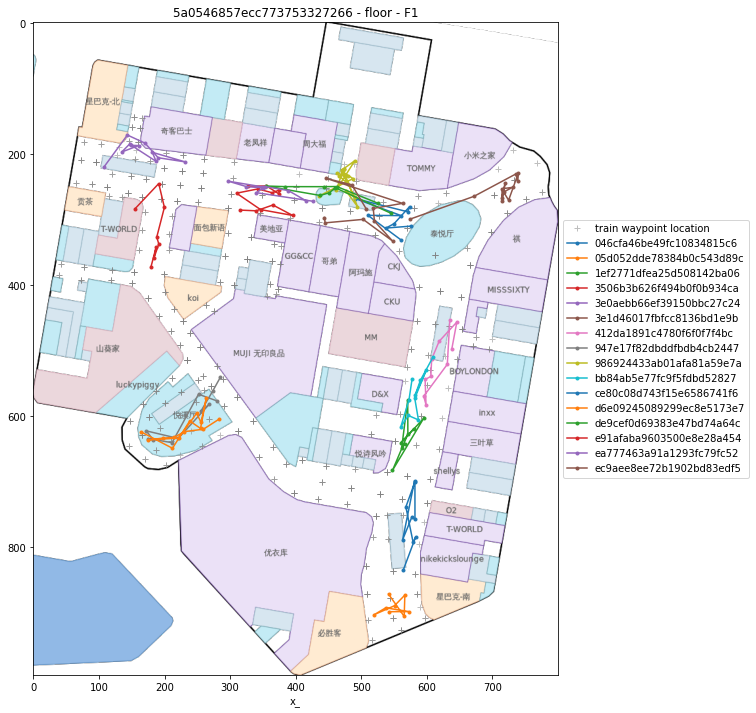

In [60]:
example_site = '5a0546857ecc773753327266'
example_floorNo = 'F1'

sub_df = sub_process(sub_df, train_waypoints)
plot_preds(example_site, example_floorNo, sub_df,
           train_waypoints, show_preds=True)

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:title={'center':'5a0546857ecc773753327266 - floor - F1'}, xlabel='x_'>)

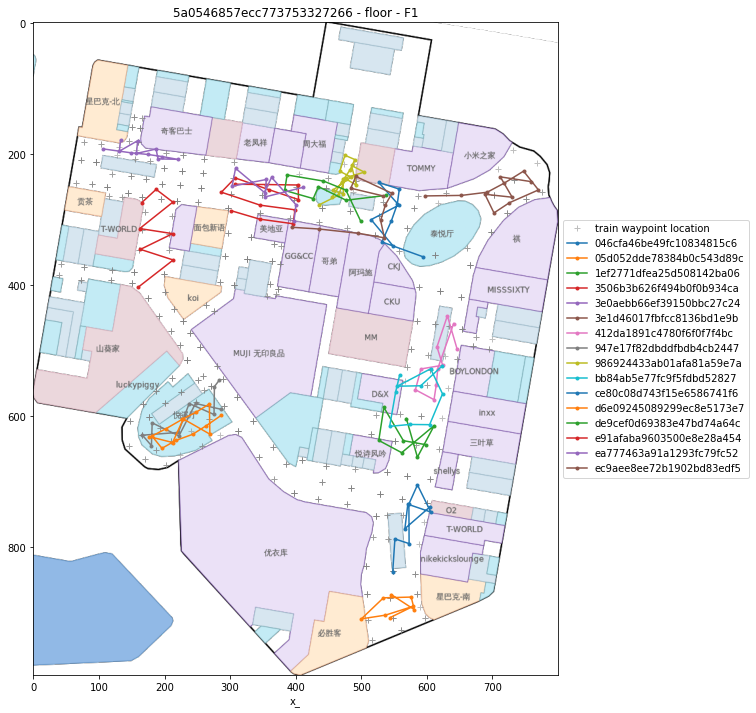

In [61]:
plot_preds(example_site, example_floorNo, sub_df_cm,
           train_waypoints, show_preds=True)

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:title={'center':'5a0546857ecc773753327266 - floor - F1'}, xlabel='x_'>)

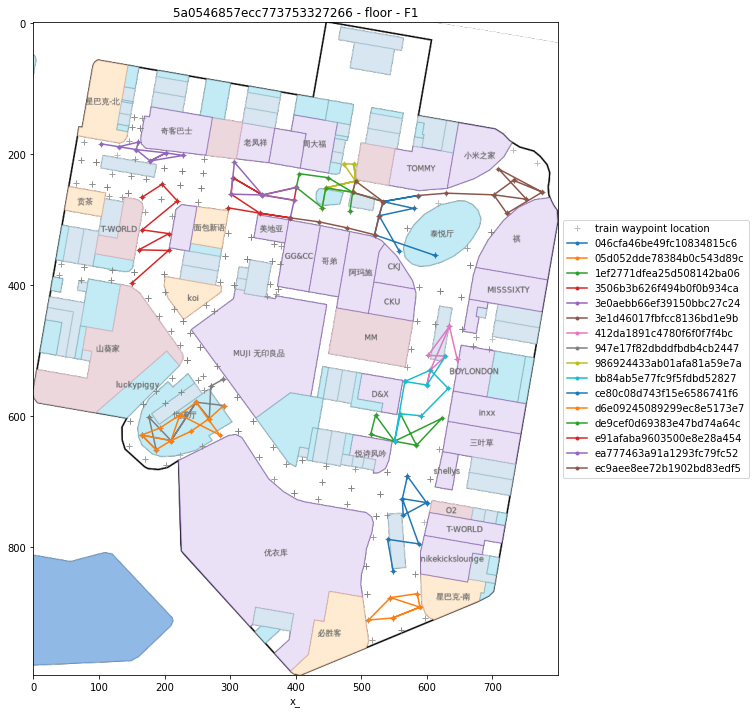

In [62]:
plot_preds(example_site, example_floorNo, sub_pp,
           train_waypoints, show_preds=True)